# Dask setup

<img src="http://dask.readthedocs.io/en/latest/_images/dask_horizontal.svg"
     align="right"
     width="30%"
     alt="Dask logo">

System-wide installation:
``` bash
sudo -H python3 -m pip install --upgrade "dask[complete]"
```
On both the client, the scheduler and the workers (be careful to use the same versions)

[Dask](https://dask.org/) documentation.

Then run `dask-scheduler` on the server scheduler and `dask-worker` on the server workers:
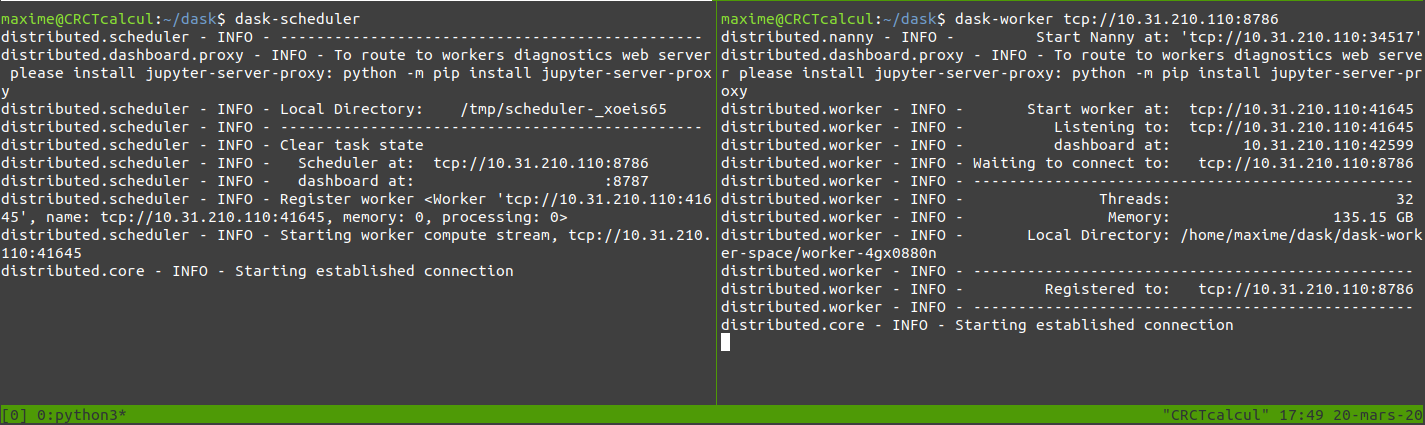

# Initialise and connect the client to the server

In [1]:
from dask.distributed import Client, progress
client = Client('tcp://10.31.210.110:8786')
client

Client Scheduler: tcp://10.31.210.110:8786 Dashboard: http://10.31.210.110:8787/status,Cluster Workers: 1 Cores: 32 Memory: 135.15 GB


# Dask delayed functions for GATE

In [2]:
from dask import delayed
import subprocess         # to run Gate
import SimpleITK as sitk  # to merge output .mhd images
import numpy as np

In [3]:
@delayed
def run_gate(gate_work, organ_id, primaries_n, job_id):
    params = f'-a [Organ_ID,{organ_id}][nb,{primaries_n}][job,{job_id}]'
    logfile = gate_work + f'output/{job_id}_log.txt'
    # open a logfile to save stdout and stderr
    with open(logfile, 'w') as f:
        subprocess.run(['Gate', params, 'mac/main.mac'], cwd=gate_work, stdout=f, stderr=subprocess.STDOUT)
    return job_id

@delayed
def merge_dose(gate_work, jobs):
    for i,job_id in enumerate(jobs):
        dose_img = sitk.ReadImage(gate_work + f'output/{job_id}_phantom-Dose.mhd')
        if (i == 0):
            dose_arr = sitk.GetArrayFromImage(dose_img)
        else:
            dose_arr += sitk.GetArrayFromImage(dose_img)
    dose_merged = sitk.GetImageFromArray(dose_arr)
    # save image as mhd
    dose_merged.CopyInformation(dose_img)
    sitk.WriteImage(dose_merged, gate_work + 'output/phantom-Dose_merged.mhd')
    return 1

@delayed
def merge_dose_std(gate_work, jobs, primaries_n):
    for i,job_id in enumerate(jobs):
        dose_img = sitk.ReadImage(gate_work + f'output/{job_id}_phantom-Dose.mhd')
        dose2_img = sitk.ReadImage(gate_work + f'output/{job_id}_phantom-Dose-Squared.mhd')
        if (i == 0):
            dose_arr = sitk.GetArrayFromImage(dose_img)
            dose2_arr = sitk.GetArrayFromImage(dose2_img)
        else:
            dose_arr += sitk.GetArrayFromImage(dose_img)
            dose2_arr += sitk.GetArrayFromImage(dose2_img)
    n = primaries_n * len(jobs)
    # calculate the absolute uncertainties
    dose_std_arr = np.sqrt((dose2_arr*n - dose_arr**2)/(n-1))
    # make it relative and handle the zeros
    dose_std_arr = np.divide(dose_std_arr, dose_arr, out=np.ones_like(dose_arr), where=(dose_arr!=0))
    dose_std_merged = sitk.GetImageFromArray(dose_std_arr)
    # save image as mhd
    dose_std_merged.CopyInformation(dose_img)
    sitk.WriteImage(dose_std_merged, gate_work + 'output/phantom-Dose-Uncertainty_merged.mhd')
    return 1

@delayed
def merge_outputs(dose, dose_std):
    return 1

# Define the simulations to run

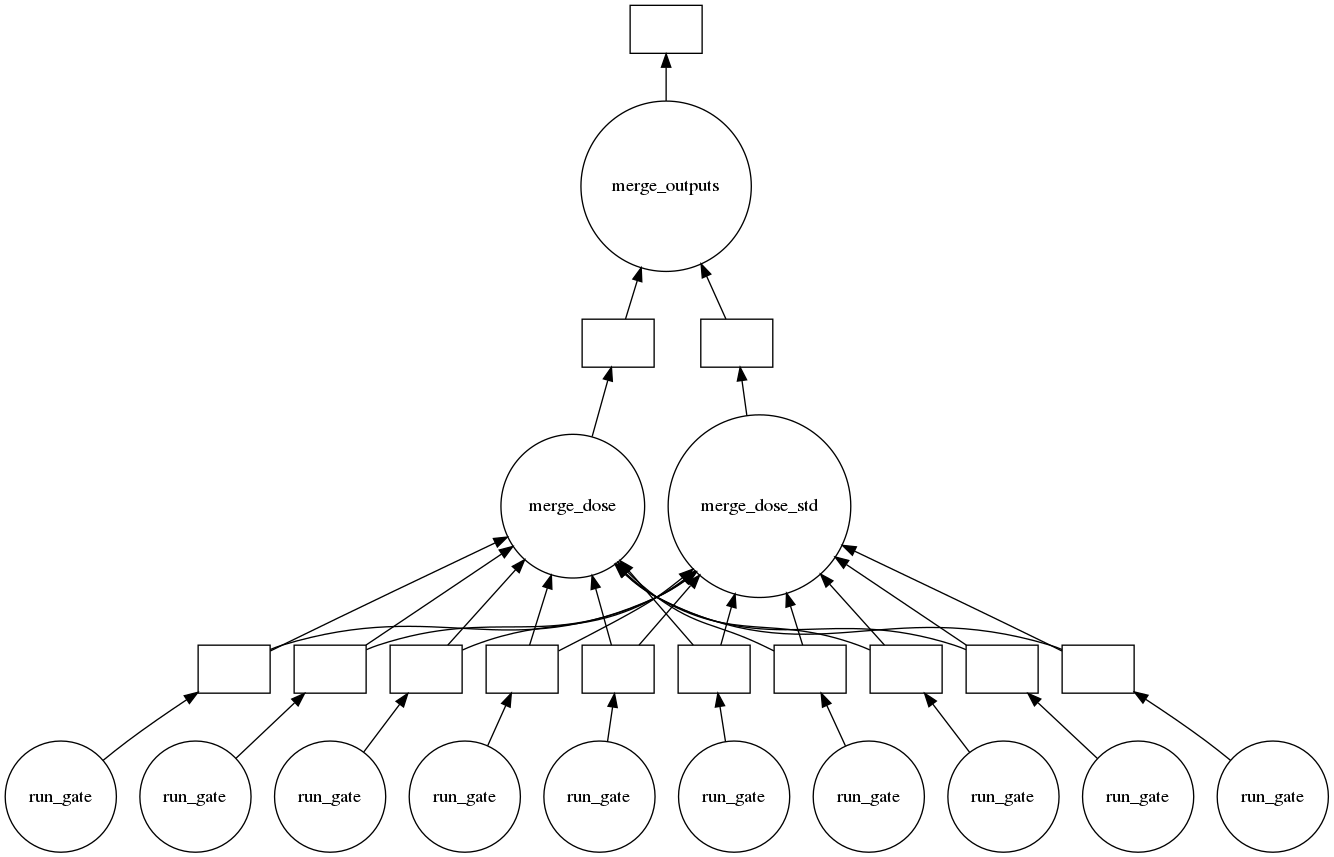

In [4]:
# folder of the application on the server
gate_work = '/home/maxime/dask/ICRP110_dosi/'

# simulation parameters
organ_id = 95
primaries_n = 1e3
jobs_n = 10

# simulation jobs
jobs = []
for job_id in range(jobs_n):
    job = run_gate(gate_work, organ_id, primaries_n, job_id)
    jobs.append(job)
# merge jobs outputs
dose = merge_dose(gate_work, jobs)
dose_std = merge_dose_std(gate_work, jobs, primaries_n)
simu = merge_outputs(dose, dose_std)

# show dask simulation graph
simu.visualize()

# Run the simulations in the background

In [5]:
futures = simu.persist()

# Get the results

In [6]:
results = futures.compute()
results

1

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError
